In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/IA1/proyecto')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/IA1/proyecto


In [1]:
#instalar yfinance para descargar los datos
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.3 MB 7.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=1ce9a6a40a1fd75778178499924f920d864b4a09643dd5959a0470d9455ae655
  Stored in directory: /tmp/pip-ephem-wheel-cache-qopnw76k/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [30]:
#Libraries

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [31]:
# Obtener datos de https://finance.yahoo.com/
from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

df = pdr.get_data_yahoo("MSFT", start="2012-01-01", end="2021-04-30")
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,26.549999,26.959999,26.389999,26.770000,21.707487,64731500
2012-01-04,26.820000,27.469999,26.780001,27.400000,22.218348,80516100
2012-01-05,27.379999,27.730000,27.290001,27.680000,22.445395,56081400
2012-01-06,27.530001,28.190001,27.530001,28.110001,22.794079,99455500
2012-01-09,28.049999,28.100000,27.719999,27.740000,22.494049,59706800
...,...,...,...,...,...,...
2021-04-23,257.880005,261.510010,257.269989,261.149994,260.050537,21462600
2021-04-26,261.660004,262.440002,260.170013,261.549988,260.448853,19763300
2021-04-27,261.579987,263.190002,260.119995,261.970001,260.867065,31014200


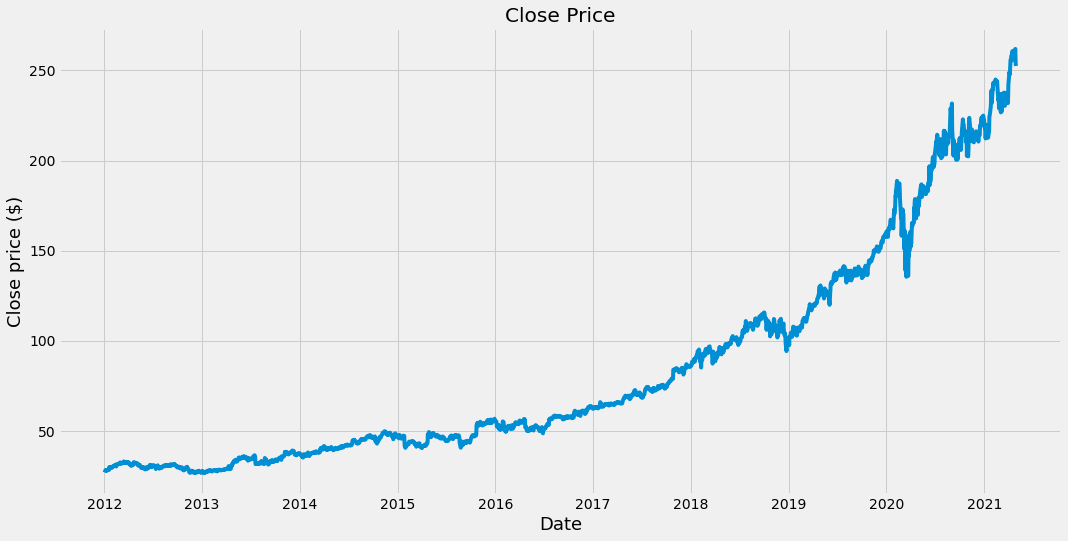

In [32]:
# Grafica los datos de la columna close
plt.figure(figsize=(16,8))
plt.title('Close Price')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price ($)', fontsize=18)
plt.show()

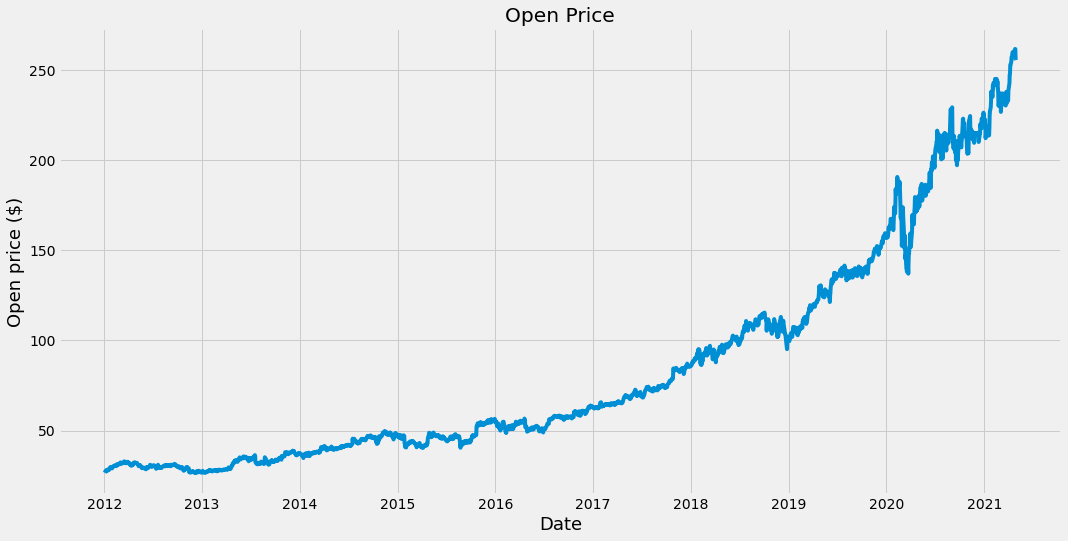

In [93]:
# Grafica los datos de la columna Open
plt.figure(figsize=(16,8))
plt.title('Open Price')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open price ($)', fontsize=18)
plt.show()

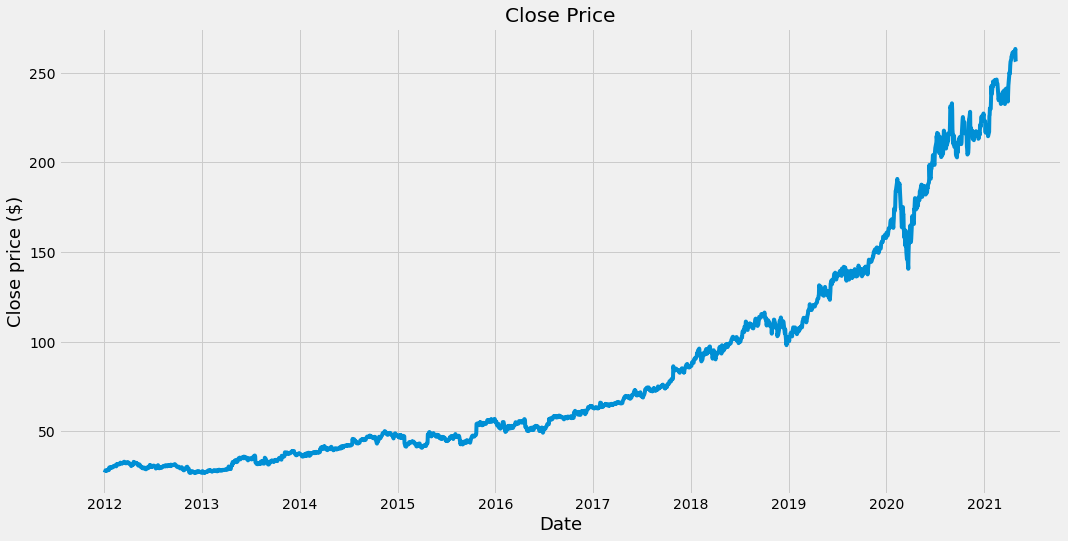

In [34]:
# Grafica los datos de la columna High
plt.figure(figsize=(16,8))
plt.title('High Price')
plt.plot(df['High'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('High price ($)', fontsize=18)
plt.show()

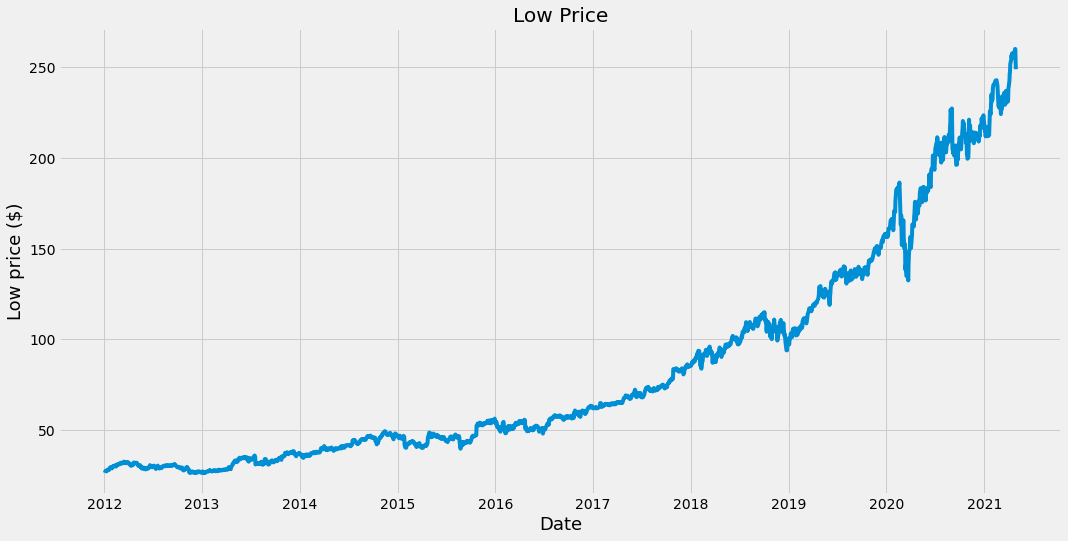

In [94]:
# Grafica los datos de la columna Low
plt.figure(figsize=(16,8))
plt.title('Low Price')
plt.plot(df['Low'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Low price ($)', fontsize=18)
plt.show()

In [36]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,26.549999,26.959999,26.389999,26.770000,21.707487,64731500
2012-01-04,26.820000,27.469999,26.780001,27.400000,22.218348,80516100
2012-01-05,27.379999,27.730000,27.290001,27.680000,22.445395,56081400
2012-01-06,27.530001,28.190001,27.530001,28.110001,22.794079,99455500
2012-01-09,28.049999,28.100000,27.719999,27.740000,22.494049,59706800


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2346 entries, 2012-01-03 to 2021-04-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2346 non-null   float64
 1   High       2346 non-null   float64
 2   Low        2346 non-null   float64
 3   Close      2346 non-null   float64
 4   Adj Close  2346 non-null   float64
 5   Volume     2346 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 128.3 KB


In [38]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2346.000000,2346.000000,2346.000000,2346.000000,2346.000000,2.346000e+03
mean,83.692992,84.490294,82.873708,83.728278,79.578554,3.461167e+07
std,59.172117,59.844107,58.493795,59.202408,60.318801,1.829513e+07
min,26.379999,26.629999,26.260000,26.370001,21.707487,7.425600e+06
25%,40.245001,40.462501,39.835001,40.202499,34.923298,2.319468e+07
50%,57.424999,57.735001,57.070002,57.424999,53.131256,3.028550e+07
75%,110.022503,111.187498,108.790003,109.659998,106.275043,4.073922e+07
max,261.660004,263.190002,260.170013,261.970001,260.867065,2.484285e+08


In [110]:
#Tomamos del dataframe solo la columna
df2 = df['Close']
df2 = pd.DataFrame(df2)

In [111]:
#Elegimos los dias para predecir
predict_days = 500
#Cambiamos el indice por los dias para predecir y creamos 
#una nueva columna para las predicciones
prediction = df2['Close'].shift(-predict_days)
df2['Prediction'] = prediction

In [112]:
#Obtenemos los datos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X = np.array(df2.drop(['Prediction'], 1))[:-predict_days]
y = np.array(df2['Prediction'])[:-predict_days]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [113]:
# Implementamos los algoritmos de regresion lineal y decisiontreeregressor
tree = DecisionTreeRegressor()
lr = LinearRegression()
tree.fit(x_train, y_train)
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [114]:
x_test = df2.drop(['Prediction'], 1)[:-predict_days]
x_test = x_test.tail(predict_days)
x_test = np.array(x_test)

In [115]:
#Realizamos la prediccion
tree_prediction = tree.predict(x_test)
lr_prediction = lr.predict(x_test)

In [116]:
predictions = lr_prediction 
valid = df2[X.shape[0]:]  
valid['Predictions'] = predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


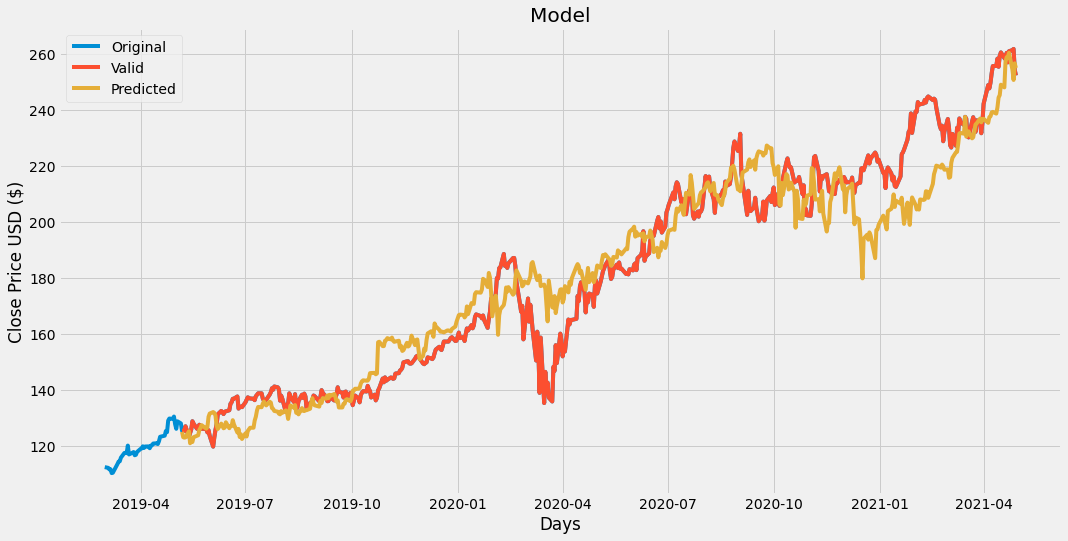

In [117]:
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.plot(df2['Close'][1800:])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(["Original", "Valid", 'Predicted'])
plt.show()

In [118]:
predictions = tree_prediction 
valid = df2[X.shape[0]:]  
valid['Predictions'] = predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


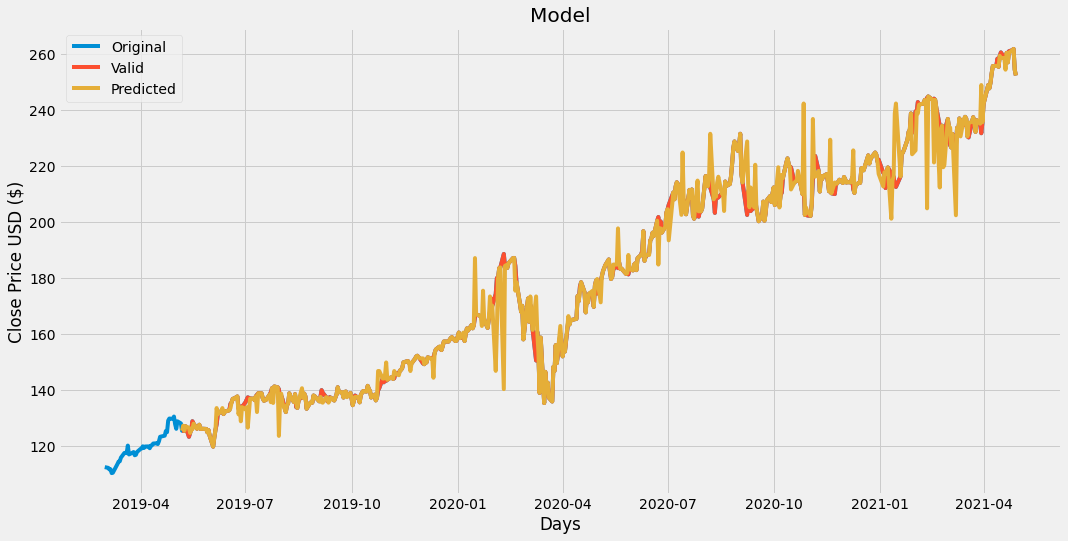

In [119]:
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel('Days')
plt.ylabel('Close Price USD ($)')
plt.plot(df2['Close'][1800:])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(["Original", "Valid", 'Predicted'])
plt.show()

In [58]:
#Dataframe con solo la columna 'Close'
data = df.filter(['Close'])
datanp = data.values
sizedata = math.ceil(len(datanp)*.8)
print(data.shape[0] ,sizedata)

2346 1877


In [59]:
#Escalar los datos entre 0 y 1 
sc = MinMaxScaler(feature_range=(0,1))
scdata = sc.fit_transform(datanp)

In [60]:
#Datos de entrenamiento
datos_train = scdata[0:sizedata, :]
x_train =[]
y_train = []
#30 
#120
for i in range(60, len(datos_train)):
  x_train.append(datos_train[i-60:i,0])
  y_train.append(datos_train[i, 0])
print(x_train[0])
print(y_train[0])

x_train = np.array(x_train)
y_train = np.array(y_train)

[0.00169779 0.00437181 0.00556027 0.0073854  0.00581494 0.00623939
 0.00573004 0.0069185  0.00797962 0.00802207 0.00789473 0.00742784
 0.01417656 0.01426145 0.01260611 0.01353989 0.01328523 0.01213921
 0.01375212 0.01341256 0.01494057 0.01519525 0.01642614 0.01625637
 0.01689304 0.01820882 0.01867572 0.01752971 0.01786927 0.01646859
 0.01561969 0.02088285 0.02071307 0.02151952 0.02079796 0.02122241
 0.0216893  0.02113752 0.02334465 0.02279286 0.02512733 0.024236
 0.02304753 0.02202886 0.02321731 0.02393887 0.02385399 0.02406621
 0.02674023 0.02716468 0.02750423 0.02644311 0.02474533 0.02385399
 0.02351443 0.02389643 0.02393887 0.02640068 0.02610356 0.02470288]
0.02440576436053185


In [61]:
#Datos de prueba
#Arreglo de datos escalados sobrantes
datos_test = scdata[sizedata-60 : , :]
x_test = [] 
y_test = datanp[sizedata : , :]
for i in range(60, len(datos_test)):
  x_test.append(datos_test[i-60:i,0])
x_test = np.array(x_test)

In [62]:
#Remodelamos de 2D a 3D x_test
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [63]:
#Remodelamos de 2D a 3D x_train
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# RNN - Recurrent neural network
<img src="https://miro.medium.com/max/250/1*T_ECcHZWpjn0Ki4_4BEzow.gif" style="width:100px;">
<img src="https://miro.medium.com/max/960/1*gEA0-LTj05xtESA5XoBxPw.gif" style="width:100px;">
<img src="https://miro.medium.com/max/1400/1*WMnFSJHzOloFlJHU6fVN-g.gif" style="width:100px;">


In [64]:
#Creamos modelo RNN con SimpleRNN
model = Sequential([
                    tf.keras.layers.SimpleRNN(30, return_sequences=True, input_shape=(x_train.shape[1], 1)),
                    tf.keras.layers.SimpleRNN(60, return_sequences=False),
                    tf.keras.layers.Dense(10),
                    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 60, 30)            960       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 60)                5460      
_________________________________________________________________
dense (Dense)                (None, 10)                610       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 7,041
Trainable params: 7,041
Non-trainable params: 0
_________________________________________________________________


In [65]:
#Compilemos el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [66]:
#Entrenamos el modelo
model.fit(x_train, y_train, batch_size=1, epochs=1)

1817/1817 [==============================] - 23s 12ms/step - loss: 5.1968e-04


In [67]:
#Predicciones
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

In [68]:
#Calculamos el RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

10.969019540766752

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


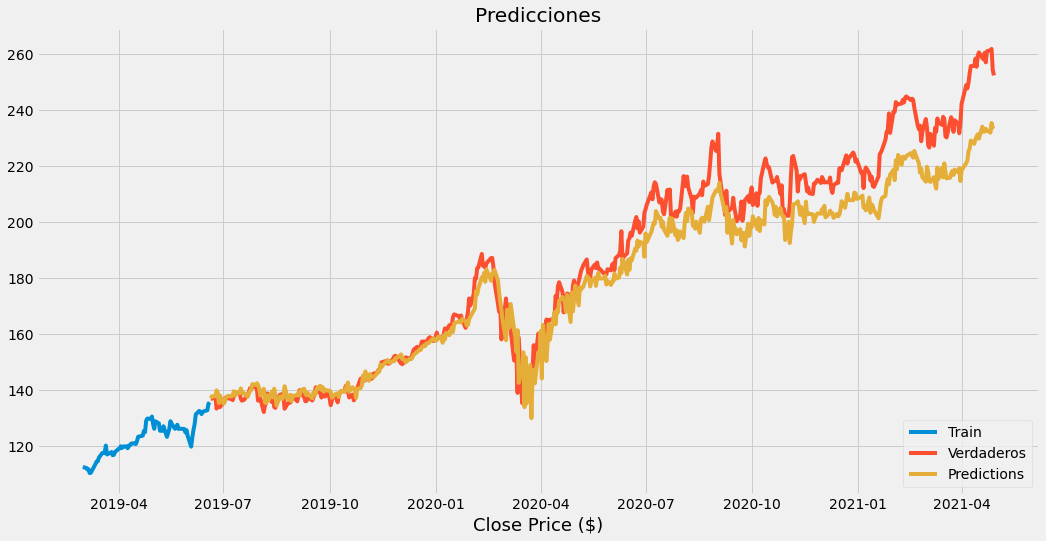

In [69]:
train = data[:sizedata]
verdaderos = data[sizedata:]
verdaderos['Predictions'] = predictions
#Graficar
plt.figure(figsize=(16,8))
plt.title('Predicciones')
plt.xlabel('Date', fontsize=18)
plt.xlabel('Close Price ($)', fontsize=18)
plt.plot(train['Close'][1800:])
plt.plot(verdaderos[['Close', 'Predictions']])
plt.legend(['Train', 'Verdaderos', 'Predictions'], loc='lower right')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


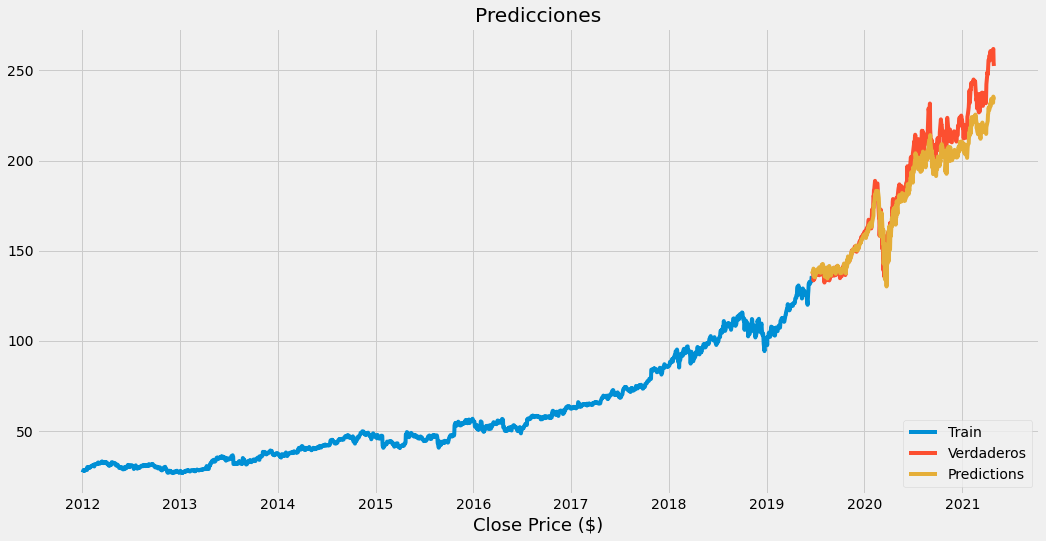

In [70]:
train = data[:sizedata]
verdaderos = data[sizedata:]
verdaderos['Predictions'] = predictions
#Graficar
plt.figure(figsize=(16,8))
plt.title('Predicciones')
plt.xlabel('Date', fontsize=18)
plt.xlabel('Close Price ($)', fontsize=18)
plt.plot(train['Close'][:])
plt.plot(verdaderos[['Close', 'Predictions']])
plt.legend(['Train', 'Verdaderos', 'Predictions'], loc='lower right')

plt.show()

# LSTM - Long short-term memory
<img src="https://programmerclick.com/images/179/e9bddf6344dd1612d56407c7658cb68b.gif" >
<img src="https://programmerclick.com/images/590/2f59ab10b8617cd6b5ac76e92d80723e.gif" >
<img src="https://programmerclick.com/images/144/fc59857eb45673525ded81f9860aa270.gif" >
<img src="https://miro.medium.com/max/1400/1*VOXRGhOShoWWks6ouoDN3Q.gif" >


In [71]:
#Creamos el modelo RNN con LSTM 
model = Sequential([
                    tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(x_train.shape[1], 1)),
                    tf.keras.layers.LSTM(60, return_sequences=True),
                    tf.keras.layers.LSTM(30, return_sequences=True),
                    tf.keras.layers.LSTM(30, return_sequences=True),
                    tf.keras.layers.LSTM(15, return_sequences=True),
                    tf.keras.layers.LSTM(15, return_sequences=False),
                    tf.keras.layers.Dense(25),
                    tf.keras.layers.Dense(1)
])


In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 60)            14880     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 30)            10920     
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 30)            7320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 15)            2760      
_________________________________________________________________
lstm_5 (LSTM)                (None, 15)                1860      
_________________________________________________________________
dense_2 (Dense)              (None, 25)               

In [82]:
#Creamos el modelo RNN con LSTM mas optimo creado
model = Sequential([
                    tf.keras.layers.LSTM(60, return_sequences=True, input_shape=(x_train.shape[1], 1)),
                    tf.keras.layers.LSTM(60, return_sequences=False),
                    tf.keras.layers.Dense(25),
                    tf.keras.layers.Dense(1)                    
])

In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 60)            14880     
_________________________________________________________________
lstm_9 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1525      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 26        
Total params: 45,471
Trainable params: 45,471
Non-trainable params: 0
_________________________________________________________________


In [84]:
#Compilemos el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [85]:
#Entrenamos el modelo
model.fit(x_train, y_train, batch_size=1, epochs=1)

1817/1817 [==============================] - 42s 22ms/step - loss: 2.5992e-04


In [86]:
#Predicciones
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

In [87]:
#Calculamos el RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

7.166019037057191

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


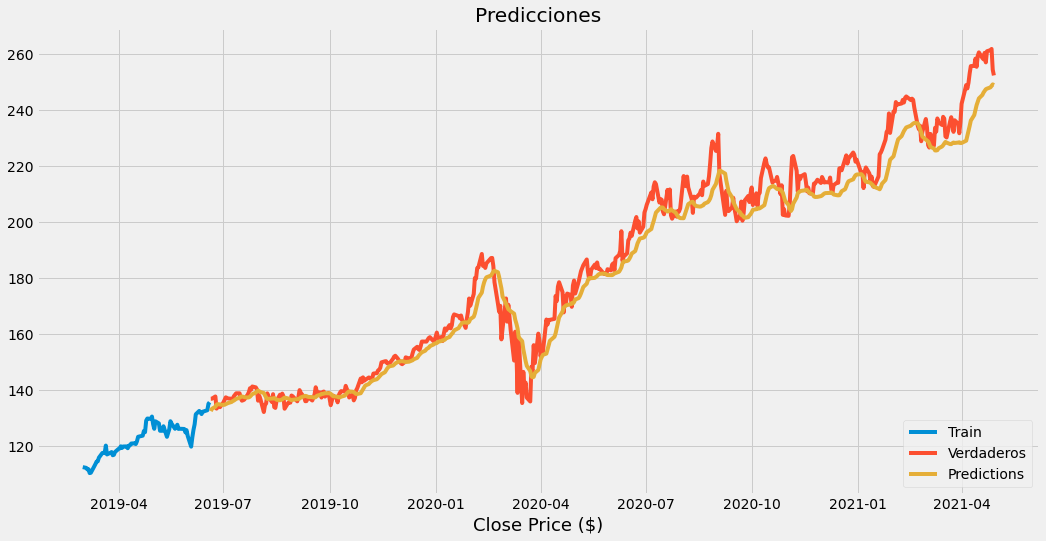

In [88]:
train = data[:sizedata]
verdaderos = data[sizedata:]
verdaderos['Predictions'] = predictions
#Graficar
plt.figure(figsize=(16,8))
plt.title('Predicciones')
plt.xlabel('Date', fontsize=18)
plt.xlabel('Close Price ($)', fontsize=18)
plt.plot(train['Close'][1800:])
plt.plot(verdaderos[['Close', 'Predictions']])
plt.legend(['Train', 'Verdaderos', 'Predictions'], loc='lower right')

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


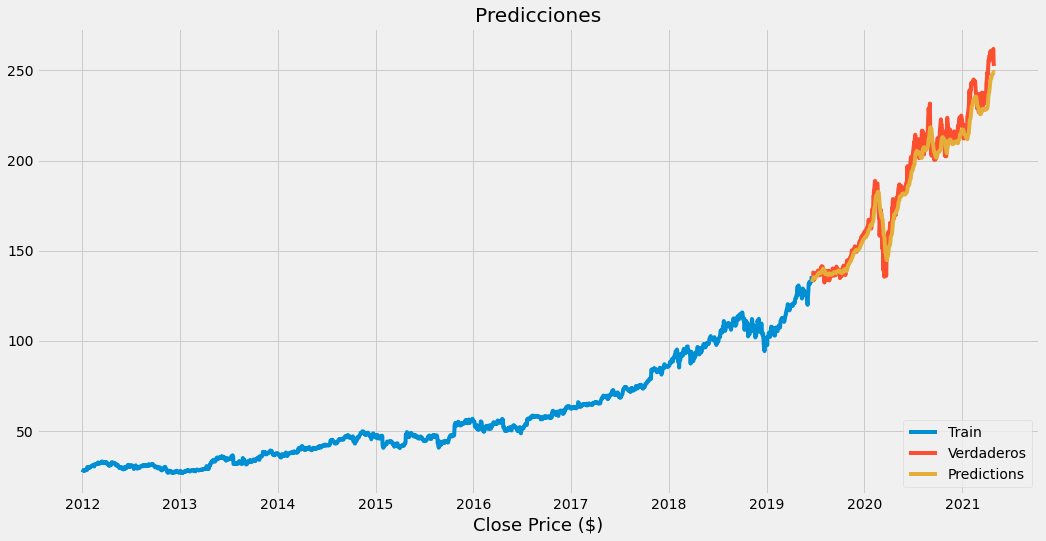

In [89]:
train = data[:sizedata]
verdaderos = data[sizedata:]
verdaderos['Predictions'] = predictions
#Graficar
plt.figure(figsize=(16,8))
plt.title('Predicciones')
plt.xlabel('Date', fontsize=18)
plt.xlabel('Close Price ($)', fontsize=18)
plt.plot(train['Close'][:])
plt.plot(verdaderos[['Close', 'Predictions']])
plt.legend(['Train', 'Verdaderos', 'Predictions'], loc='lower right')

plt.show()